In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fried_liver_otb import select_board

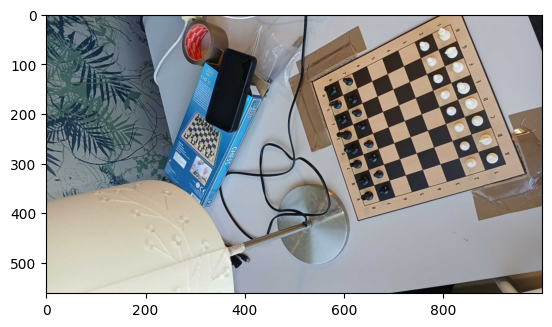

In [2]:
img_raw = cv2.imread("resources/daytime_desk_capture.jpg")
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
# board = select_board.transform_board(img_raw[0:400,550:950,:])
# plt.imshow(board)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:3623: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


In [ ]:
#cv2.imwrite("resources/daytime_desk_capture_clean.jpg", board)

True

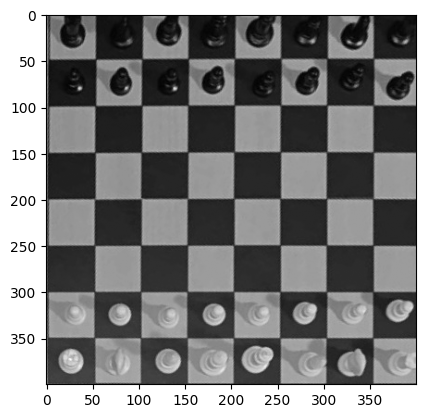

In [4]:
board = cv2.imread("resources/nighttime_desk_capture_clean.jpg")
grey = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap="grey")

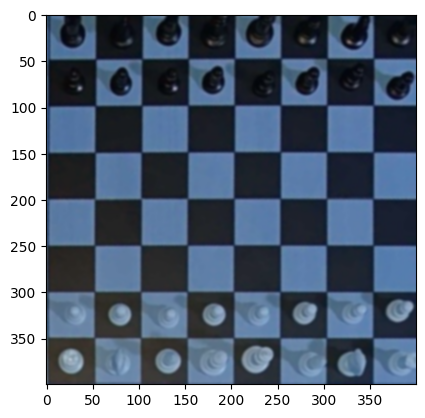

In [5]:
blurred = cv2.GaussianBlur(board, (5, 5), 0)
plt.imshow(blurred)

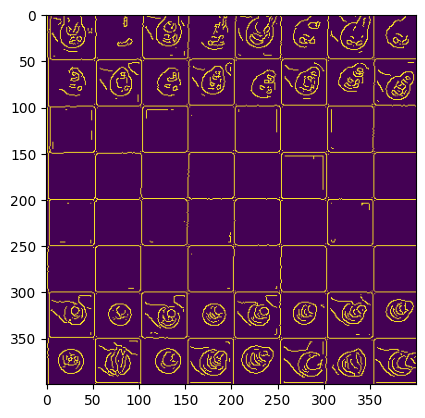

In [6]:
edges = cv2.Canny(blurred, 20, 50)
plt.imshow(edges)

In [7]:
alpha = 3  # Increase contrast (1.0 - 3.0)
beta = 0    # Keep brightness the same

# Apply contrast change
adjusted = cv2.convertScaleAbs(board, alpha=alpha, beta=beta)

# Show images
cv2.imshow("Original", board)
cv2.imshow("Contrast Adjusted", adjusted)
cv2.waitKey(0)
cv2.destroyAllWindows()

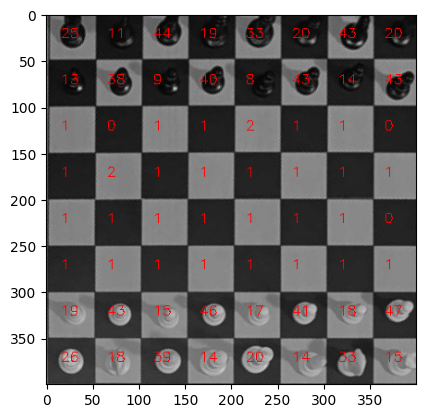

In [18]:
def square_stats(img, dims=[400,400], squares=[8,8], margin=15, annotate_out = ""):

    img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img_mean = np.zeros(squares)
    img_sd = np.zeros(squares)

    size_x = dims[0]/squares[0]
    size_y = dims[1]/squares[1]

    for i in range(0, squares[0]):
        for j in range(0, squares[1]):
            x1, x2 = int(i * size_x + margin), int((i+1) * size_x - margin)
            y1, y2 = int(j * size_y + margin), int((j+1) * size_y - margin)
            sq = img[y1:y2, x1:x2]

            img_mean[i,j] = np.mean(sq)
            img_sd[i,j] = np.std(sq)

            if annotate_out:
                if annotate_out == "mean":
                    img_out = cv2.putText(img_out,str(round(img_mean[i,j])), (x1,y1 + 10),
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0))
                elif annotate_out == "sd":
                    img_out = cv2.putText(img_out,str(round(img_sd[i,j])), (x1,y1 + 10),
                                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0))
                elif annotate_out == "sq":
                    img_out = cv2.rectangle(img_out, (x1,y1), (x2,y2), (255,0,0))
                
    if annotate_out:
        return(img_mean, img_sd, img_out)
        
    return(img_mean, img_sd)


means, sds, img = square_stats(grey, annotate_out="sd")

plt.imshow(img)



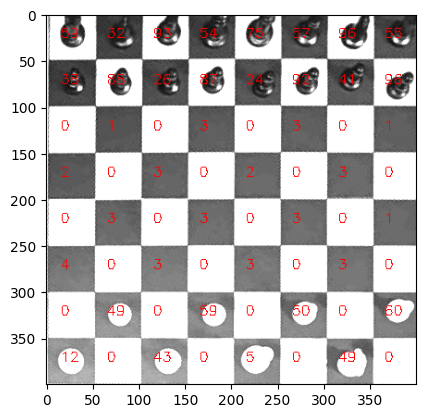

In [20]:
alpha = 3  # Increase contrast (1.0 - 3.0)
beta = 0    # Keep brightness the same

# Apply contrast change
adjusted = cv2.convertScaleAbs(grey, alpha=alpha, beta=beta)

means, sds, img = square_stats(adjusted, annotate_out="sd")

plt.imshow(img)

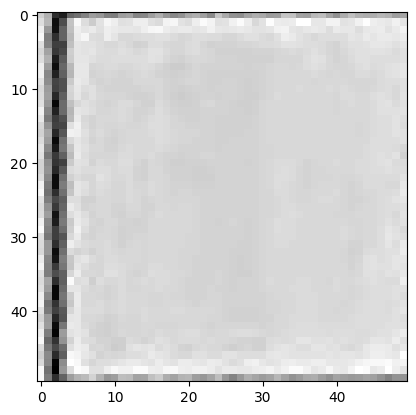

In [13]:
x=100
y=0
plt.imshow(grey[x:x+50,y:y+50],cmap="grey")

In [20]:
grey

array([[119, 111,  79, ...,  13,  13,  14],
       [110, 108,  73, ...,  14,  13,  13],
       [110, 116,  66, ...,  15,  14,  13],
       ...,
       [146, 106,  61, ..., 145, 145, 148],
       [140, 108,  52, ..., 142, 149, 142],
       [141, 109,  75, ...,  86,  80,  88]], shape=(400, 400), dtype=uint8)

In [35]:
def top_n(mat,n):
    vals = np.sort(np.ravel(mat))
    threshold = vals[-n]
    mask = np.greater_equal(mat, threshold)
    if sum(np.ravel(mask)) > n:
        raise("Could not identify top n")
    return(mask)

arr = [[1,2,3],
       [2,2,3],
       [4,2,1]]

top_n(arr, 3)

array([[False, False,  True],
       [False, False,  True],
       [ True, False, False]])

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


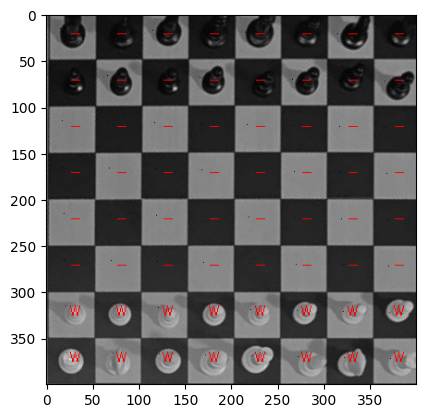

In [64]:
def detect_pieces(img, colour="white", n_pieces=16, annotate_out = False, threshold = 60, margin_colour=20, margin_sd = 15):

    if annotate_out:
        img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if colour == "black":
        # use higher contrast for detecting black pieces
        high_contrast = cv2.convertScaleAbs(img, alpha=3, beta=0)
    else:
        high_contrast = img

    sq_sd = np.zeros((8,8))
    print(sq_sd)
    for i in range(0, 8):
        for j in range(0, 8):
            x1, x2 = int(i * 50), int((i+1) * 50)
            y1, y2 = int(j * 50), int((j+1) * 50)
            
            im_col = img[y1+margin_colour:y2-margin_colour, x1+margin_colour:x2-margin_colour]
            im_sd = high_contrast[y1+margin_sd:y2-margin_sd, x1+margin_sd:x2-margin_sd]

            col_mean = np.mean(im_col)
            if (colour == "white" and col_mean >= threshold) or (colour == "black" and col_mean < threshold):
                # if the square is a colour match, save the variation
                sq_sd[i, j] = np.std(im_sd)
            else:
                # otherwise set it to zero
                sq_sd[i, j] = 0

    pieces = top_n(sq_sd, n_pieces)

    if annotate_out:
        img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i in range(0, 8):
            for j in range(0, 8):
                x, y = int(i * 50+25), int(j * 50+25)
                if pieces[i,j]:
                    tex = colour[0]
                else:
                    tex = "-"
                cv2.putText(img_out,tex.upper(), (x,y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0))
                
        return(pieces, img_out, sq_sd)
    
    return(pieces, sq_sd)


mask, img, sq_sd = detect_pieces(grey, annotate_out=True)

plt.imshow(img)
#print(sq_sd)


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


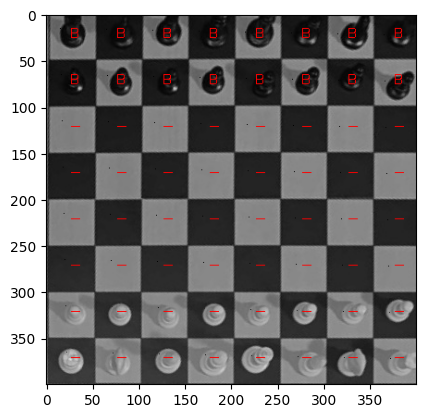

In [65]:
mask, img, sq_sd = detect_pieces(grey, colour="black", annotate_out=True)

plt.imshow(img)

In [32]:
arr = [[1,2,3],
       [2,2,3],
       [4,2,1]]

np.greater_equal(arr, 1)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [58]:
sq_sd = np.zeros((8,8))
sq_sd

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [63]:
"a".upper()

'A'